<a href="https://colab.research.google.com/github/DevanshSaini18/Social-distancing-detection-YOLOv3/blob/main/Object%20detection%20yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Pafy is a Python library to download YouTube content and retrieve metadata. ... In order to install pafy we use the command given below


In [1]:
!pip install pafy
!pip install youtube_dl

### In order to download yolov3 weights we run the below cell

In [2]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2021-07-10 14:06:52--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  43.6MB/s    in 5.8s    

2021-07-10 14:06:58 (40.8 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2021-07-10 14:06:58--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      


### OpenCV-Python(cv2) is a library of Python bindings designed to solve computer vision problems
### Imutils are a series of convenience functions to make basic image processing functions such as translation, rotation, resizing etc
### Numpy is used for trigonometric, statistical, and algebraic routines
### cv2_imshow to display frames of video in google colab(cv2.imshow does not work in colab)
### clear_output to clear output after each frame is displayed

In [3]:
import pafy
import cv2
import imutils
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

### Using pafy to use youtube video of given url

In [4]:
url = "https://youtu.be/2bKXv_XviFc?t=00:50"
video = pafy.new(url)
best = video.getbest()
vs = cv2.VideoCapture(best.url)

### Setting labelPaths and extracting label names from coco.names list

In [5]:
labelsPath = "/content/coco.names"
LABELS = []
with open(labelsPath) as f:
	line = f.readlines()
	for class_name in line:
		class_name = class_name.strip("\n")
		LABELS.append(class_name)
print("Length of LABELS : ",len(LABELS))
person_index = LABELS.index("person")

Length of LABELS :  80


### Setting weights path and config path 
### 1) yolov3.weights : The pre-trained weights
### 2) yolov3.cfg : The configuration file.
### Giving the configuration and weight files for the model and load the network using them.
### setting the preferable target to cv.dnn.DNN_TARGET_OPENCL to run it on a GPU


In [6]:
weightsPath = "/content/yolov3.weights"
configPath = "/content/yolov3.cfg"
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath) 
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

ln = net.getLayerNames()                                    
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]  
print(ln)                                           

['yolo_82', 'yolo_94', 'yolo_106']


### a) MIN_CONF - Defining the min confidence required to accept a detected box . If our model have detected a box having confidence lesser than MIN_CONF then it would neglect that box
### b) NMS_THRESH - Defining the min threshold iou(Intersection over Union) value required for diferent boxes to be considered detecting the same object. Box with higher score would be kept and other would be removed
### c) max_dist - Defining the minimum allowable distance between two persons (on pixel plane) 

In [7]:
MIN_CONF = 0.3
NMS_THRESH = 0.4
max_dist = 50

### Measures euclidean distance between the center of two boxes (on pixel plane)

In [8]:
def find_dist(box1,box2):
	centre1 = ((box1[0]+box1[2])/2,(box1[1]+box1[3])/2)
	centre2 = ((box2[0]+box2[2])/2,(box2[1]+box2[3])/2)
	dist = np.sqrt((centre1[0]-centre2[0])**2+(centre1[1]-centre2[1])**2)
	return (dist < max_dist)

### Find whether two boxes violate the minimum allowable distance condition. And  returns a list of pairs of each pair found violating and a set of all indices found violating with any other box

In [9]:
def find_violations(results):
    length = len(results)
    too_close_pairs = []
    too_close_set = set()
    for i in range(length):
        for j in range(i):
            dist_bool = find_dist(results[i],results[j])
            if dist_bool:
                too_close_pairs.append((i,j))
                too_close_set.add(i)
                too_close_set.add(j)
    return too_close_pairs,too_close_set

### Draws a box using opencv with the set of indices of all the people violating the min distance condition 
### Red Boxes for violation  and green for non - violation  

In [10]:
def draw_rect(results,too_close_set):
	for i in range(len(results)):
		violated = True if i in too_close_set else False
		box = results[i]
		(startX,startY,endX,endY) = box
		if violated:
			# draw red rectangle
			cv2.rectangle(frame, (startX, startY), (endX, endY),(0,0,255), 2)
		else:
			cv2.rectangle(frame, (startX, startY), (endX, endY),(0,255,0), 2)
	return 

### Draws a line between each pair found violating the min distance condition (i.e they are closer to each other than min_dist)

In [11]:
def draw_line(results,too_close_pair):
    for i,j in too_close_pair:
        box1 = results[i]
        box2 = results[j]
        centre1 = ((box1[0]+box1[2])/2,(box1[1]+box1[3])/2)
        centre2 = ((box2[0]+box2[2])/2,(box2[1]+box2[3])/2)
        cv2.line(frame, (int(centre1[0]),int(centre1[1])), (int(centre2[0]), int(centre2[1])), (255, 255, 0), thickness=1, lineType=1)        
    return

### For recognizing Person object and its location 
### If the detected object is having confidence > MIN_CONF then it would be accepted else ignored
### Later on applying NMS suppression to remove multiple boxes denoting same object,i.e if iou value of two boxes is greater than NMS_Thresh then box with higher score will remain and other would be removed  
### At last returing the coordinates of bounding box found

In [12]:
def get_coordinates_of_people(frame,nn,ln,person_index):
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),swapRB=True, crop=False)
	net.setInput(blob)
	layerOutputs = net.forward(ln)   
	boxes = []
	confidences = []
	(H, W) = frame.shape[:2]
	for output in layerOutputs:
		for detection in output:
			classID = np.argmax(detection[5:])
			confidence = detection[5:][classID]
			if classID == person_index and confidence > MIN_CONF:
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))
				boxes.append([x, y, int(width), int(height)])
				confidences.append(float(confidence))
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, MIN_CONF, NMS_THRESH) 
	results = []
	if len(idxs) == 0:
		return []
	for i in idxs.flatten():
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
		results.append((x, y, x + w, y + h))
	return results

### Using opencv for frame by fame analysis for object detection and calling required functions for detection and drawing showing and clearing output 

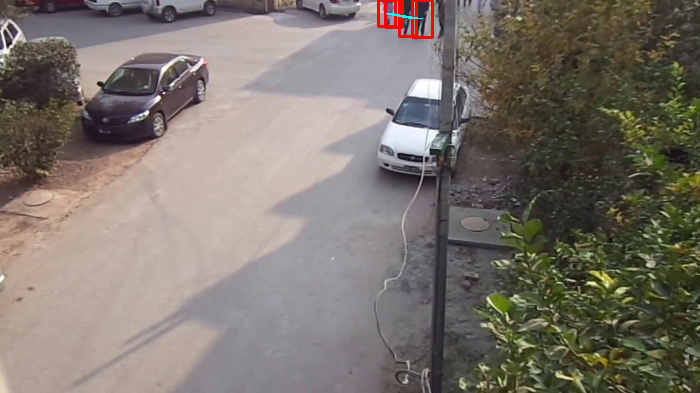

In [ ]:
count = 0
while True:
	(grabbed, frame) = vs.read()
	if count%20!=0:
		count =  count + 1
		continue
	count = count + 1
	if not grabbed:
		break
	frame = imutils.resize(frame, width=700)
	results = get_coordinates_of_people(frame, net, ln,person_index)
	too_close_pairs, too_close_set =  find_violations(results)
	draw_rect(results,too_close_set)
	draw_line(results,too_close_pairs)
	cv2_imshow(frame)
	clear_output(wait=True)